# Bayesian t-test (JZS method)
In order to compute Bayes factor for comparison of continuous data (against 0 or against another group, paired or not), we rely on the JZS Bayes factor implementation. With this method, a point null hypothesis of 0 is compared against a prior Cauchy distribution with scale of 0.707 (default). I have simply written a wrapper around the penguoin t-test implementation, so that it can easily be applied to time resolved or cross temporal analyses.

The function can perform 3 different kinds of tests:
- A one sample t-test against a specified value: some argument x and scalar (i.e. single number) as y (**decoding accurracy against 0.5 for example**)
- An independent two sample t-test: x and y must have the same shape and paired must be set to false
- A paired sample t-test: x and y must have the same shape and paired must be set to true (**comparing decoding accuracy within subject between two conditions**)

These tests can be performed on 1D, 2D and 3D data (in each case one sample, two sample, independent or not):
- 1D data: apply t-test on a single set of observation (single data point or something like that), for which you must pass a 1D numpy array as x and y matching your expected test
- 2D data: apply t-test on different sets of data points (time point by time point for time resolved signal), for which you must pass a 2D numpy array as x and y matching your expected test
- 3D data: apply t-test on different sets of "pairs" data points (time by time or time by frequency), for which you must pass a 3D numpy array as x and y matching your expected test

The data must be ordered as follows:
- 1D data: (n) n observations
- 2D data: (n, t) n observations at each time point t
- 3D data: (n, t, freq) n observations at each time-frequency "pixel"
- 3D data: (n, t, t) n observations at each time-by-time "pixel"

The function returns a single bayes factor for the 1D data, and an array matching the higher dimension for the others:

Here are concrete examples:

## 1D and 1 sample t-test

In [1]:
from scipy.stats import halfnorm
import numpy as np
import matplotlib.pyplot as plt
from bayes_factor_fun import bayes_ttest, sim_decoding_binomial

# Generate some data that are normally distribution around 0:
x = np.random.normal(0, 1, size=100)
# Compute the Bayes factor against 0:
bf = bayes_ttest(x, y=0, paired=False, alternative='two-sided', r=0.707)
print(f'BF10={bf}')

# Generate some data not centered on 0:
x = np.random.normal(0.2, 1, size=100)
# Compute the Bayes factor against 0:
bf = bayes_ttest(x, y=0, paired=False, alternative='two-sided', r=0.707)
print(f'BF10={bf}')

# Compare against 0.5
x = np.random.normal(0.2, 1, size=100)
# Compute the Bayes factor against 0:
bf = bayes_ttest(x, y=0.3, paired=False, alternative='two-sided', r=0.707)
print(f'BF10={bf}')


We will conduct a one-sample t-test for 1 point(s).
BF10=0.145
We will conduct a one-sample t-test for 1 point(s).
BF10=0.17
We will conduct a one-sample t-test for 1 point(s).
BF10=0.297


## 1D and 2 sample independent t-test

In [2]:
# Generate some data that are normally distribution around 0:
x = np.random.normal(0, 1, size=100)
y = np.random.normal(0.3, 1, size=100)
# Compute the Bayes factor against 0:
bf = bayes_ttest(x, y=y, paired=False, alternative='two-sided', r=0.707)
print(f'BF10={bf}')

We will conduct a two-sample t-test for 1 point(s).
BF10=0.706


## 1D and 2 sample paired t-test

In [3]:
# Generate some data that are normally distribution around 0:
x = np.random.normal(0, 1, size=100)
y = np.random.normal(0.3, 1, size=100)
# Compute the Bayes factor against 0:
bf = bayes_ttest(x, y=y, paired=True, alternative='two-sided', r=0.707)
print(f'BF10={bf}')

We will conduct a paired t-test for 1 point(s).
BF10=3.102


# 2D 1 sample t-test (decoding accuracy against 0.5)

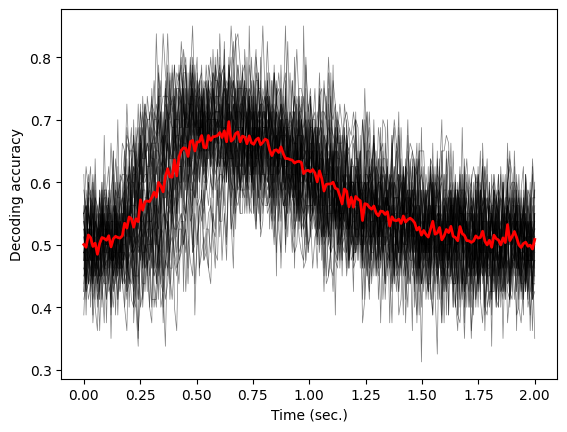

We will conduct a one-sample t-test for 200 point(s).


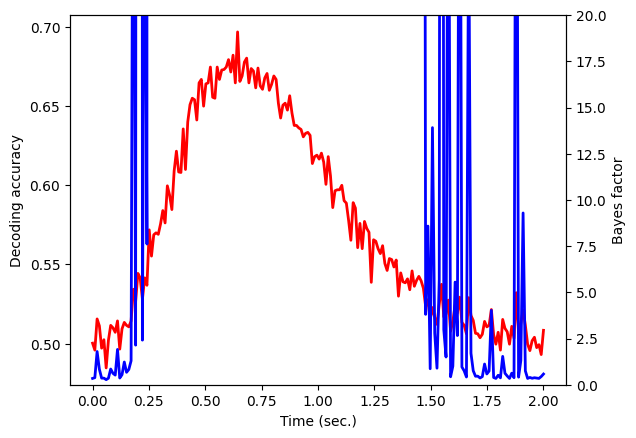

In [ ]:
# Create a time vector:
times = np.linspace(0, 2, 200)
n_subjects = 40
subjects_decoding = []
ntrials = 80

for sub in range(n_subjects):
    # Simulate decoding accuracy for every subject using a binomial distribution, assuming each subject had a 100 trials:
    sub_decoding = sim_decoding_binomial(0, 2, 100, scale_factor=np.random.normal(5, 0.3, size=1), tstart=halfnorm.rvs(0, 0.4, size=1), ntrials=ntrials)
    subjects_decoding.append(np.sum((np.array(sub_decoding)), axis=1) / ntrials)

# Convert to a numpy array:
subjects_decoding = np.asarray(subjects_decoding)
# We have 20 subjects, times n data points:
subjects_decoding.shape
# Plot the data to illustrate them:
fig, ax = plt.subplots()
ax.plot(times, subjects_decoding.T, linewidth=0.5, color='k', alpha=0.5)
ax.plot(times, np.mean(subjects_decoding, axis=0), linewidth=2, color='r')
ax.set_ylabel('Decoding accuracy')
ax.set_xlabel('Time (sec.)')
plt.show()

# Compute the Bayes factor:
bf = bayes_ttest(subjects_decoding, y=0.5, paired=False, alternative='greater', r=0.707)

# Plot the Bayes factor against the decoding accuracy:
fig, ax = plt.subplots()
ax.plot(times, np.mean(subjects_decoding, axis=0), linewidth=2, color='r')
ax2 = ax.twinx()
ax2.plot(times, bf, linewidth=2, color='b')
ax2.set_ylim([0, 20])
ax.set_ylabel('Decoding accuracy')
ax2.set_ylabel('Bayes factor')
ax.set_xlabel('Time (sec.)')
plt.show()

# Binomial test

In order to compute a Bayes factor for the binomial distribution, we are using beta-binomial test. The likelihood of the data is defined by the beta distribution, while the prior is defined with a beta distribution. Since the two are conjugate, we can compute the model evidence analytically. We are therefore comparing the model evidence between a point null hypothesis ($P(\Theta=0.5) = 1$) against an alternative hypothesis of a flat prior: all decoding accuracies are equally likely.

Specifically, the model evidence for the null is defined as the probability mass function of the binomial distribution at for $\Theta=0.5$. The model evidence for the alternative hypothesis is computed analytically. 

The function to use is called binomial_bf and takes the following inputs
- y: a numpy array containing ones and zeros, ones correspond to correct decoding of a given trial, 0 corresponds to incorrect decoding
- theta_h0: the null hypothesis. The default is set to 0.5, which is chance decoding
- prior_h1: parameters of the prior beta distribution. Default to [1, 1], i.e. flat prior

The function can be used as follows:

## How to use

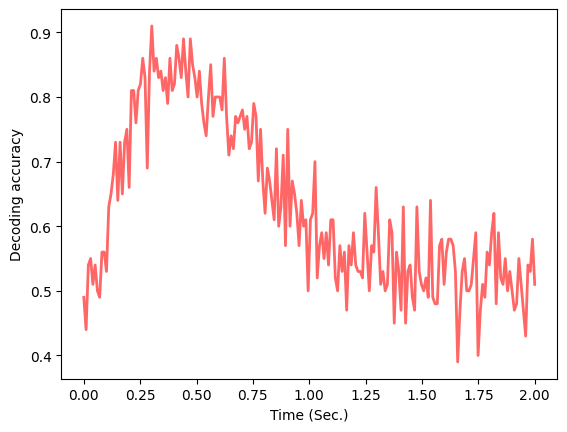

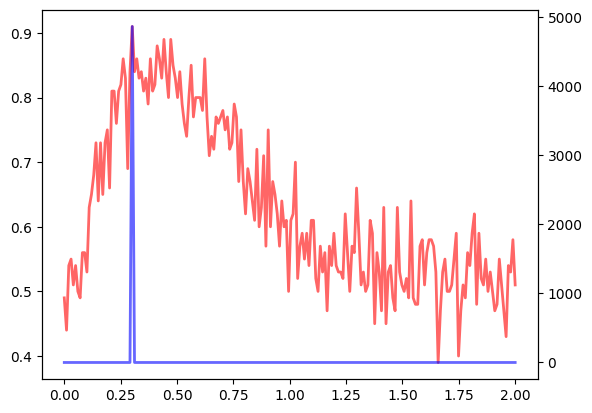

In [5]:
import numpy as np
from scipy.stats import gamma, binomtest
import matplotlib.pyplot as plt
from bayes_factor_fun import binomial_bf, sim_decoding_binomial

# Simulate a time series of decoding accuracy:
obs = sim_decoding_binomial(0, 2, 100, scale_factor=3, tstart=0, ntrials=100)
fig, ax = plt.subplots(1, 1)
ax.plot(np.linspace(0, 2, 200), np.sum((np.array(obs)), axis=1) / 100, 'r-', lw=2, alpha=0.6, label='gamma pdf')
ax.set_ylabel('Decoding accuracy')
ax.set_xlabel('Time (Sec.)')
plt.show()

# Compute the Bayes factor:
bf = []
for t in obs:
    bf.append(binomial_bf(t, prior_h1=[4, 2]))

# Plot the bayes factor on a separate axis:
fig, ax = plt.subplots(1, 1)
ax.plot(np.linspace(0, 2, 200), np.sum((np.array(obs)), axis=1) / 100, 'r-', lw=2, alpha=0.6, label='gamma pdf')
ax2 = ax.twinx()
ax2.plot(np.linspace(0, 2, 200), np.array(bf), 'b-', lw=2, alpha=0.6, label='gamma pdf')
plt.show()


# Simulation:
In order to validate our calculation of the bayes factor, I will compute the bayes factor and binomial t-test with 100 trials starting from an accuracy of 50% all the way to a 100:

Accuracy=0.5
p-val=1.0
BF=1.831574460900288e-30
Accuracy=0.51
p-val=0.9204107626128211
BF=1.9048374393363196e-30
Accuracy=0.52
p-val=0.7643534344026669
BF=2.1427477480861427e-30
Accuracy=0.53
p-val=0.6172994135892521
BF=2.607374173053745e-30
Accuracy=0.54
p-val=0.48411841360729146
BF=3.4325803608021564e-30
Accuracy=0.55
p-val=0.36820161732669576
BF=1.2166134792674147e-29
Accuracy=0.56
p-val=0.2712530240738354
BF=1.961328396879578e-29
Accuracy=0.5700000000000001
p-val=0.19334790449564282
BF=3.4271414799598266e-29
Accuracy=0.5800000000000001
p-val=0.13321061920721386
BF=6.493730976977976e-29
Accuracy=0.5900000000000001
p-val=0.08862608011406765
BF=1.3349481799362726e-28
Accuracy=0.6000000000000001
p-val=0.056887933640980784
BF=2.9792136210772754e-28
Accuracy=0.6100000000000001
p-val=0.03520020021770479
BF=7.222683278791291e-28
Accuracy=0.6200000000000001
p-val=0.02097873567785172
BF=1.903630289268442e-27
Accuracy=0.6300000000000001
p-val=0.012032975725363479
BF=5.459059264815344e-27
Accu

Text(0, 0.5, 'Bayes Factor')

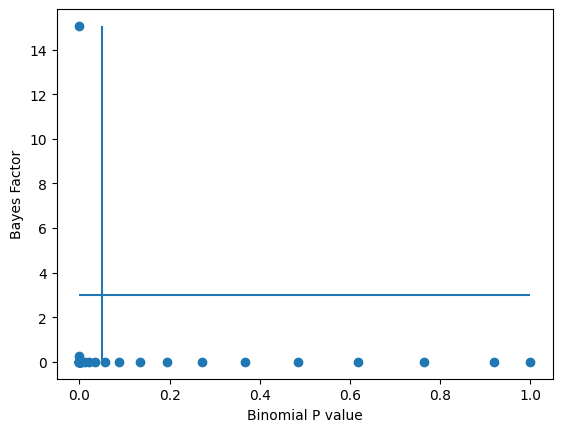

In [6]:
# Accuracies:
accuracies = np.arange(0.5, 0.9, 0.01)
n_trials = 100

p_values = []
bf = []

for acc in accuracies:
    print('='*40)
    print(f'Accuracy={acc}')
    # Calucate the number of successes:
    n_success = n_trials * acc
    # Compute the p value:
    binom_res = binomtest(int(n_success), n_trials, alternative='two-sided')
    
    p_values.append(binom_res.pvalue)
    print(f'p-val={binom_res.pvalue}')
    # Create the vector of successes:
    y = np.array([1] * int(n_success) + [0] * int(n_trials - n_success))
    # Compute the Bayes factor:
    bf.append(binomial_bf(y, prior_h1=[2, 2]))
    print(f'BF={bf[-1]}')

# Plot the results:
fig, ax = plt.subplots()
ax.scatter(np.array(p_values), np.array(bf))
ax.hlines(3, np.min(p_values), np.max(p_values))
ax.vlines(0.05, np.min(bf), np.max(bf))
ax.set_xlabel('Binomial P value')
ax.set_ylabel('Bayes Factor')